In [39]:
import pandas as pd
import numpy as np
import re
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import pycaret as pc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set_theme()

In [40]:
TablaCompleta = pd.read_csv('TablaCompleta.csv')
Reportes = pd.read_csv('Reportes.csv')

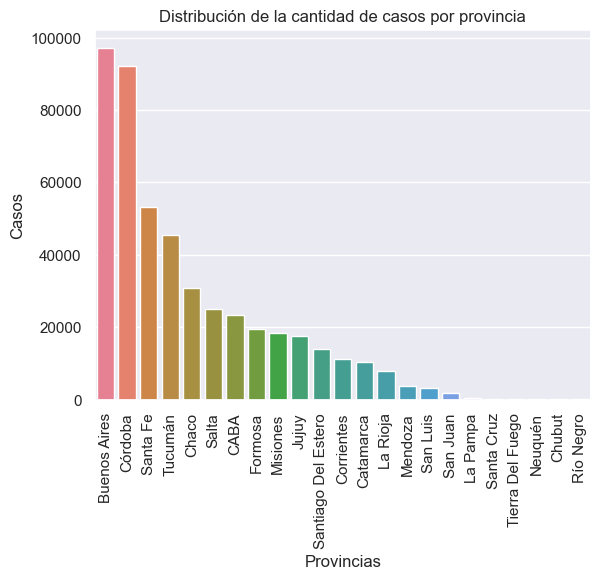

In [41]:
casos_provincia = TablaCompleta.groupby('prov')['cantidad'].sum()
casos_provincia = pd.DataFrame(casos_provincia)
casos_provincia.reset_index(inplace=True)

paleta = sns.color_palette("husl", len(casos_provincia['prov'].unique()))

sns.barplot(x='prov', y='cantidad', data=casos_provincia, palette=paleta, order=casos_provincia.sort_values('cantidad', ascending=False)['prov'])
plt.title('Distribución de la cantidad de casos por provincia')
plt.xlabel('Provincias')
plt.ylabel('Casos')
plt.xticks(rotation=90)
plt.show()

Vemos que la mayoría de los casos reportados pertenecen a PBA seguido por Córdoba y Santa Fe

In [42]:
def month_name_to_number(month_name):
    month_abbr = month_name[:3].capitalize()
    return list(calendar.month_abbr).index(month_abbr) 

Meses = Reportes['mes'].apply(month_name_to_number)

# Le cambio el formato a la columna meses
Meses = pd.to_datetime(Meses, format='%m').dt.month


# Me aseguro que figure como series para poder hacer los siguientes pasos
Meses = pd.Series(Meses)

# Nuevo df con los datos que necesito
df_analisis = pd.DataFrame({'Mes': Meses, 'año': Reportes['año'], 'Cantidad': Reportes['cantidad'].astype(int)})

# Vuelvo a tirar el format %m por si acaso
df_analisis['Mes'] = pd.to_datetime(df_analisis['Mes'], format='%m').dt.month


# Hago una columna para los cuatrimestres
df_analisis['Cuatrimestre'] = df_analisis['Mes'].apply(lambda x: (x - 1) // 3 + 1)

# Hago otra que incluye columna y año en un formato donde es facilmente ordenable
df_analisis['Cuatrimestre Completo'] = df_analisis.apply(lambda row: f"{row['año']} Q{(row['Mes'] - 1) // 3 + 1}", axis=1)

df_analisis

,Mes,año,Cantidad,Cuatrimestre,Cuatrimestre Completo
0,3,2018,1,1,2018 Q1
1,2,2018,1,1,2018 Q1
2,2,2018,1,1,2018 Q1
3,3,2018,1,1,2018 Q1
4,3,2018,1,1,2018 Q1
...,...,...,...,...,...
45587,3,2024,1,1,2024 Q1
45588,1,2024,1,1,2024 Q1
45589,5,2024,1,2,2024 Q2
45590,3,2024,1,1,2024 Q1


In [43]:
df_analisis.to_numpy()
cuatrimestre_sumatorias = df_analisis.groupby('Cuatrimestre Completo')['Cantidad'].sum().reset_index()
cuatrimestre_sumatorias2 = df_analisis.groupby('Cuatrimestre')['Cantidad'].sum().reset_index()
sumatoria_año = df_analisis.groupby('año')['Cantidad'].sum().reset_index()

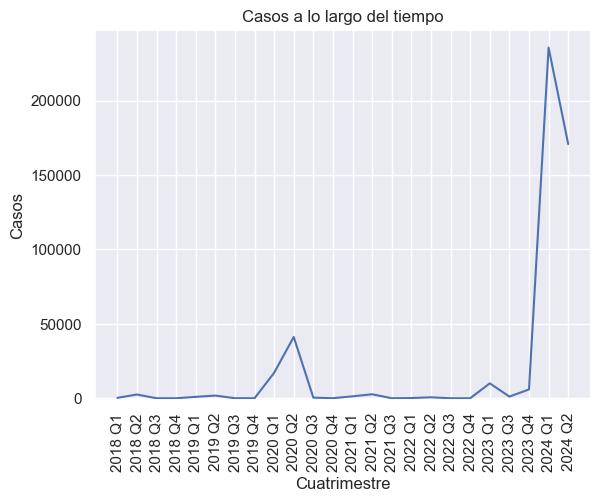

In [44]:
sns.lineplot(data=cuatrimestre_sumatorias, x='Cuatrimestre Completo', y='Cantidad')
ax = plt.gca()
ax.set_ylim(bottom=0-1000, top=max(cuatrimestre_sumatorias['Cantidad'] * 1.05))  # Limites superior e inferior
y_ticks = range(0, (max(cuatrimestre_sumatorias['Cantidad'])) +2000, 50000)  # Cada cuánto se muestra la cant. en el eje y
ax.set_yticks(y_ticks)

plt.title('Casos a lo largo del tiempo')
plt.xlabel('Cuatrimestre')
plt.ylabel('Casos')
plt.xticks(rotation=90)
plt.show()

Vemos que el pico de casos se encuentra en el primer cuatrimestre del 2024, mientras que tanto en 2020 y 2023 tenemos también un incremento en los casos reportados.

In [45]:
cuatrimestre_sumatorias

,Cuatrimestre Completo,Cantidad
0,2018 Q1,272
1,2018 Q2,2514
2,2018 Q3,19
3,2018 Q4,7
4,2019 Q1,942
5,2019 Q2,1797
6,2019 Q3,29
7,2019 Q4,26
8,2020 Q1,17105
9,2020 Q2,41190


In [46]:
cuatrimestre_sumatorias2

,Cuatrimestre,Cantidad
0,1,265352
1,2,219624
2,3,1583
3,4,6015


In [47]:
sumatoria_año

,año,Cantidad
0,2018,2812
1,2019,2794
2,2020,58759
3,2021,3991
4,2022,802
5,2023,17070
6,2024,406346


Estaciones: 
- Verano: Finales de diciembre - finales de marzo (Aproximable a Q1)
- Invierno: Junio a Septiembre (Q3)
- Otoño: Marzo a Junio (Q2)
- Primavera: Septiembre a Diciembre (Q4)

Si bien las estaciones no se corresponden exactamente 1 a 1 con los cuatrimestres; es evidente cómo la gran mayoría de los casos se dan en la primera mitad del año (Especialmente en el Q1), mientras que los casos en el Q3 (Que se corresponde mayormente con el invierno son casi despreciables).

También es notorio cómo hay años donde tiende a dispararse fuertemente (2020, 2023 y 2024); y cómo en 2022 hubo sólo 802 casos de Dengue y Zika. Además es notable cómo 2023 tuvo sus casos distribuídos de forma bastante más uniforme que otros años.

Habiendo recibido recientemente las estadísticas que solicitamos al SMN; el próximo objetivo a corto plazo es integrarlas al análisis de datos y ver que tantas de las observaciones se deben a fenómenos climáticos; y cuales a otros motivos (Desde manejo y desmanejo de las medidas preventivas a faltantes de recursos).

In [48]:
Reportes.groupby(
    ['evento']
).agg({
    'cantidad': ['sum']
})

,cantidad
,sum
evento,
Dengue,492500.0
Zika,74.0


Según los datos oficiales, los casos de Zika no son comparables con los de dengue

In [49]:
# Creo un filtro para eliminar datos irrelevantes
valores_eliminables = ['Menor a 1 año', 'Desconocido/Sin Especificar', 'Igual A 1 Año']
TablaCompleta_filtrada_por_edad = TablaCompleta[~TablaCompleta['edad_desc'].isin(valores_eliminables)]
TablaCompleta_filtrada_por_edad['edad_desc'].unique()


array(['De 45 A 64 Años', 'De 15 a 24 años', 'De 10 A 14 Años',
       'De 25 A 34 Años', 'De 35 A 44 Años', 'Mayor a 65 años',
       'De 5 A 9 Años', 'De 2 A 4 Años', '1 a 2 años'], dtype=object)

In [50]:

# Defino un orden de edades para tener un gráfico más claro
orden_edad = ['1 a 2 años', 'De 2 A 4 Años', 'De 5 A 9 Años', 'De 10 A 14 Años', 
              'De 15 a 24 años', 'De 25 A 34 Años', 'De 35 A 44 Años', 'De 45 A 64 Años', 'Mayor a 65 años']
orden_edad

['1 a 2 años',
 'De 2 A 4 Años',
 'De 5 A 9 Años',
 'De 10 A 14 Años',
 'De 15 a 24 años',
 'De 25 A 34 Años',
 'De 35 A 44 Años',
 'De 45 A 64 Años',
 'Mayor a 65 años']

In [51]:

# Convierto la columna 'edad_desc' en una categoría con un orden específico
TablaCompleta_filtrada_por_edad['edad_desc'] = pd.Categorical(TablaCompleta_filtrada_por_edad['edad_desc'], categories=orden_edad, ordered=True)
TablaCompleta_filtrada_por_edad


,id_depto,depto,prov_id,prov,año,evento,edad_id,edad_desc,cantidad
0,6000,*Sin Dato*,6,Buenos Aires,2018,Dengue,9,De 45 A 64 Años,1.0
1,6035,Avellaneda,6,Buenos Aires,2018,Dengue,6,De 15 a 24 años,1.0
2,6035,Avellaneda,6,Buenos Aires,2018,Dengue,9,De 45 A 64 Años,1.0
3,6035,Avellaneda,6,Buenos Aires,2018,Dengue,5,De 10 A 14 Años,1.0
4,6035,Avellaneda,6,Buenos Aires,2018,Dengue,6,De 15 a 24 años,1.0
...,...,...,...,...,...,...,...,...,...
43612,34035,Patiño,34,Formosa,2024,Dengue,3,De 2 A 4 Años,1.0
43613,22091,Maipú,22,Chaco,2024,Dengue,7,De 25 A 34 Años,1.0
43614,22014,Bermejo,22,Chaco,2024,Dengue,4,De 5 A 9 Años,1.0
43615,22043,Fray Justo Santa María De Oro,22,Chaco,2024,Dengue,7,De 25 A 34 Años,1.0


In [52]:

# Agrupo los valores por edad para ver la cantidad de casos
conteo_por_edad = TablaCompleta_filtrada_por_edad.groupby('edad_desc')['cantidad'].sum()
conteo_por_edad = pd.DataFrame(conteo_por_edad)
conteo_por_edad.reset_index(inplace=True)
conteo_por_edad


,edad_desc,cantidad
0,1 a 2 años,2188.0
1,De 2 A 4 Años,8248.0
2,De 5 A 9 Años,27310.0
3,De 10 A 14 Años,41369.0
4,De 15 a 24 años,90944.0
5,De 25 A 34 Años,92888.0
6,De 35 A 44 Años,75898.0
7,De 45 A 64 Años,1927.0
8,Mayor a 65 años,133771.0


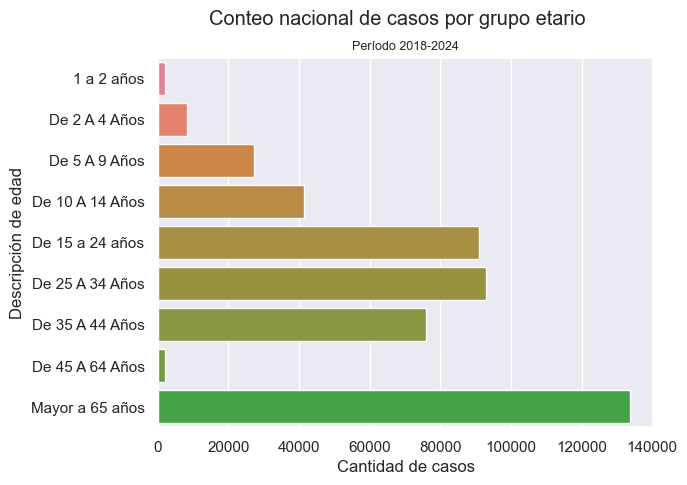

In [53]:

#Creación del gráfico de barras
sns.barplot(x='cantidad', y='edad_desc',palette=paleta, data=conteo_por_edad)
plt.suptitle('Conteo nacional de casos por grupo etario')
plt.title('Período 2018-2024', fontsize = 9)
plt.xlabel('Cantidad de casos')
plt.ylabel('Descripción de edad')
plt.show()

In [54]:
#Creamos una tabla específica para ver la distribución de casos por departamento de Buenos Aires
df_Buenos_aires = TablaCompleta[TablaCompleta['prov'] == 'Buenos Aires']

#Pasamos los datos de la columna 'cantidad' de float a int
df_Buenos_aires['cantidad'] = df_Buenos_aires['cantidad'].astype(int)

#Agrupamos los datos por departamento y sumamos la cantidad de casos 
df_depto_BsAs = df_Buenos_aires.groupby('depto')['cantidad'].sum().sort_values(ascending=False)

#Calculamos con np.percentile qué datos se encuentran dentro del percentil 90
df_depto_BsAs_percentile90 = np.percentile(df_depto_BsAs, 90)

#Agregamos la condición para graficar los departamentos con mayor concentración de casos
df_depto_BsAs_max = df_depto_BsAs[df_depto_BsAs >= df_depto_BsAs_percentile90]

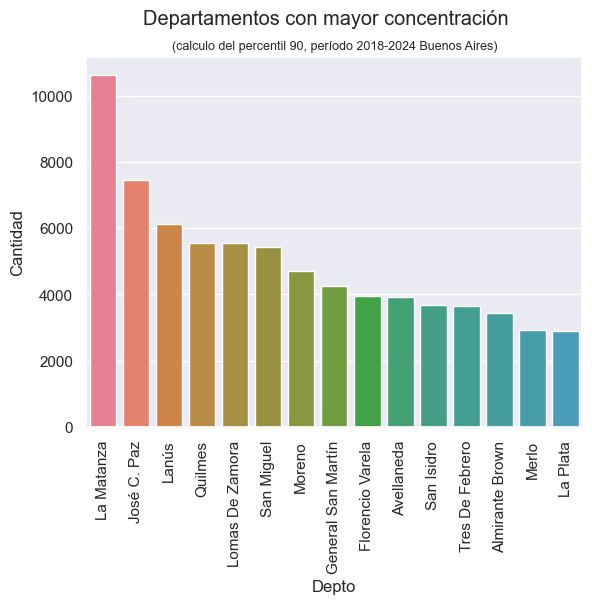

In [55]:
#Creamos el gráfico de barra específico para los departamentos
sns.barplot(df_depto_BsAs_max, palette=paleta)
plt.suptitle('Departamentos con mayor concentración')
plt.title('(calculo del percentil 90, período 2018-2024 Buenos Aires)', fontsize = 9)
plt.xlabel('Depto')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)
plt.show()